# EUR/USD Forecasting: A Hybrid LSTM-GRU + XGBoost Baseline Univariate Model

This project presents a **baseline univariate time series model** for forecasting the **next-day EUR/USD exchange rate** using only historical closing prices. A stacked **LSTM-GRU architecture** is trained on daily data from **2007 to 2024** to capture temporal patterns in the EUR/USD market.

To enhance predictive performance, the **residuals from the RNN model** are further modeled using **XGBoost**, forming a hybrid architecture. The meta-learner focuses on correcting systematic errors left by the neural network, resulting in significant improvements in both forecast precision and directional accuracy.

This hybrid modeling approach, where residuals from a deep learning model are passed to a gradient boosting model, has been increasingly adopted in various time series applications, particularly in sectors such as finance and energy. 
Some examples can be found below:

- **"LSTM-BO-XGBoost for Stock Price Forecasting"** – Tech Science Press (2020)  
  [https://www.techscience.com/iasc/v29n3/43035](https://www.techscience.com/iasc/v29n3/43035)

- **"CNN-LSTM + XGBoost Hybrid for Stock Prediction"** – arXiv (2022)  
  [https://arxiv.org/abs/2204.02623](https://arxiv.org/abs/2204.02623)

- **"A Hybrid Deep Learning and XGBoost Model for Financial Forecasting"** – arXiv preprint (2025)  
  [https://arxiv.org/html/2506.22055v1](https://arxiv.org/html/2506.22055v1)

This **baseline** can serve as a benchmark for future experiments with **multivariate models**, incorporating macroeconomic indicators (e.g., interest rates), technical metrics, or sentiment-based features.

In [34]:
get_ipython().ast_node_interactivity = "all"

# Import the necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import random

## Data Preprocessing

In [2]:
# Load EUR/USD exchange rate (daily)
eurusd_df = yf.download("EURUSD=X", start="2007-01-01", end="2025-01-01", auto_adjust=True)[['Close']]
eurusd_df.index = pd.to_datetime(eurusd_df.index)
eurusd_df = eurusd_df.asfreq('B').ffill()
series = eurusd_df['Close'].to_numpy()
series.shape

[*********************100%***********************]  1 of 1 completed


(4697, 1)

### Visualizing EUR/USD Exchange Rate Over Time

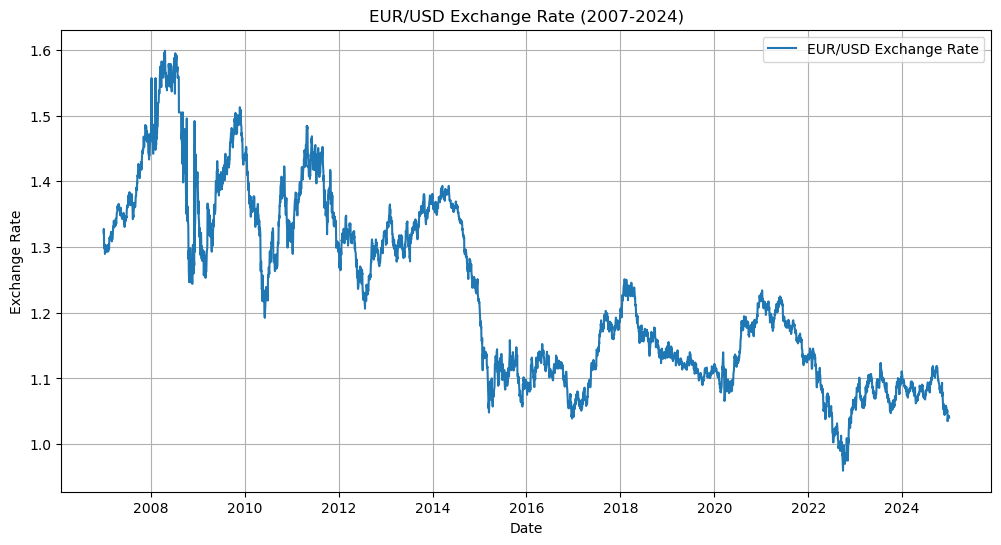

In [3]:
# Plot the EUR/USD exchange rate
plt.figure(figsize=(12, 6)) 
plt.plot(eurusd_df.index, series, label='EUR/USD Exchange Rate')
plt.title('EUR/USD Exchange Rate (2007-2024)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show();

### Generating Sliding Windows for Time Series Forecasting

In [35]:
from hybrid_forecast_utils import generate_sliding_windows
window_size = 30
horizon = 1
X, y = generate_sliding_windows(series, window_size=30, horizon=1, target_col=0)
y = y.flatten()
X.shape
y.shape

(4667, 30, 1)

(4667,)

### Splitting Data into Training and Test Sets

In [5]:
# Train/Test Split
split = int(len(X) * 0.90)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### Temporal Split of Input Feature (X) – Window Starting Points   
This plot shows the first value of each sliding 30-step input window from the train and test sets. The clean transition from blue (train) to orange (test) confirms that the chronological order is preserved.

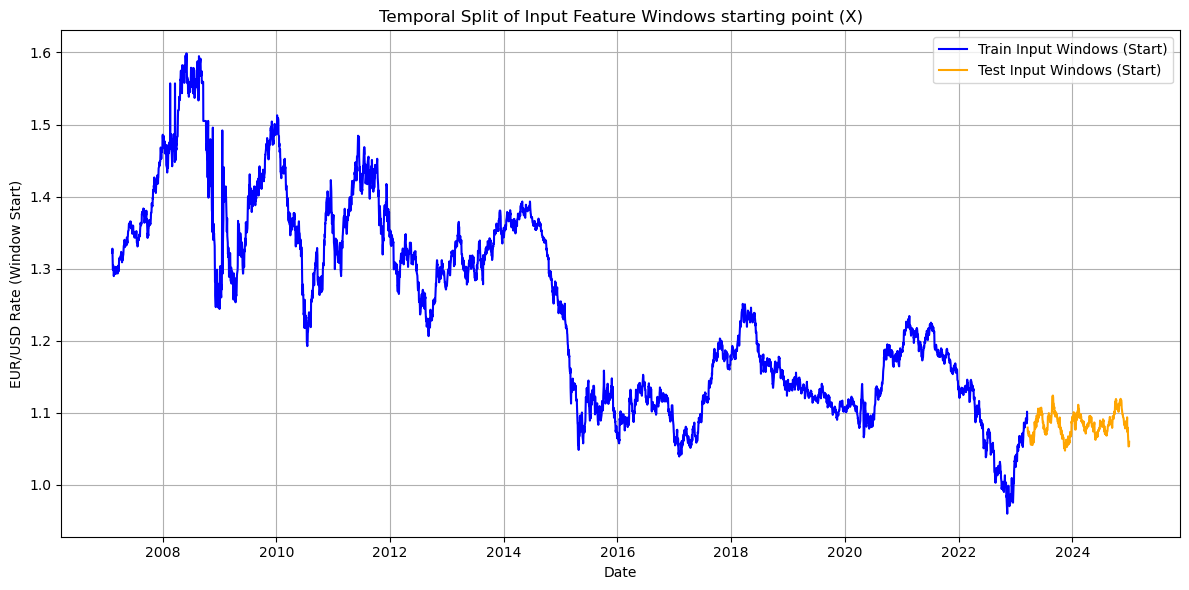

In [6]:
# Reconstruct the aligned date index after windowing
aligned_index = eurusd_df.index[window_size + horizon - 1:]

# Visual check for X_train and X_test: use first value of each window to represent the window
X_train_flat = X_train[:, 0, 0]  # First value of each training window
X_test_flat = X_test[:, 0, 0]    # First value of each test window

# Use the same aligned index for consistency
split = int(len(aligned_index) * 0.9)
train_index = aligned_index[:split]
test_index = aligned_index[split:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_index, X_train_flat, label='Train Input Windows (Start)', color='blue')
plt.plot(test_index, X_test_flat, label='Test Input Windows (Start)', color='orange')
plt.title('Temporal Split of Input Feature Windows starting point (X)')
plt.xlabel('Date')
plt.ylabel('EUR/USD Rate (Window Start)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

### Target Variable Over Time: Train vs Test Set

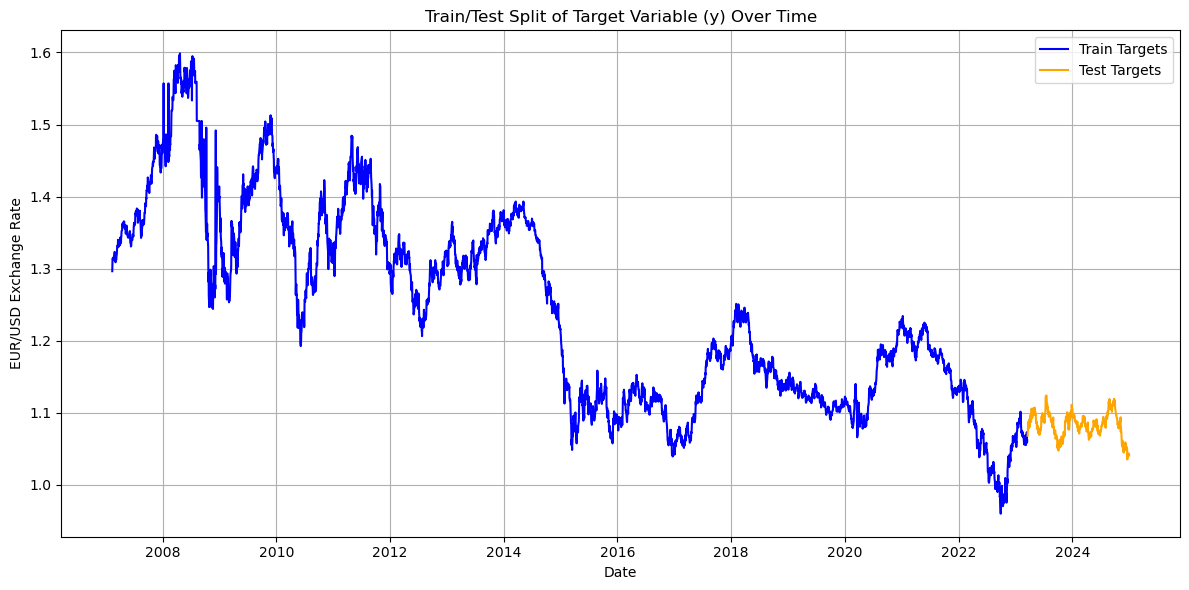

In [7]:
# Reconstruct the aligned date index after windowing
aligned_index = eurusd_df.index[window_size + horizon - 1:]

# Compute split point for target
split = int(len(aligned_index) * 0.9)
train_index = aligned_index[:split]
test_index = aligned_index[split:]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train, label='Train Targets', color='blue')
plt.plot(test_index, y_test, label='Test Targets', color='orange')
plt.title('Train/Test Split of Target Variable (y) Over Time')
plt.xlabel('Date')
plt.ylabel('EUR/USD Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

In [ ]:
from hybrid_forecast_utils import scale_and_cast
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = scale_and_cast(X_train, X_test, y_train, y_test)

In [9]:
print("X_train_scaled.shape:", X_train_scaled.shape)
print("y_train_scaled.shape:", y_train_scaled.shape)
print("X_test_scaled.shape:", X_test_scaled.shape)
print("y_test_scaled.shape:", y_test_scaled.shape)

X_train_scaled.shape: (4200, 30, 1)
y_train_scaled.shape: (4200,)
X_test_scaled.shape: (467, 30, 1)
y_test_scaled.shape: (467,)


## Model Architecture: LSTM-GRU Stacked RNN

The base model is a univariate sequence-to-one regressor, using a hybrid RNN architecture:
- A **stacked combination** of LSTM and GRU layers to capture short- and long-term dependencies in the EUR/USD time series.
- **Dropout layers** are used after each recurrent layer to prevent overfitting.
- The model is trained to predict the **next-day exchange rate** based on the previous 30 days.

Hyperparameters such as the number of units, dropout rates, and optimizer type are tuned using **Bayesian Optimization via Keras Tuner**.

In [10]:
num_features = X_train_scaled.shape[2]

In [11]:
# Clear previous Keras sessions and set random seeds for reproducibility
tf.keras.backend.clear_session()
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW

def build_baseline(hp):
    # Hyperparameters
    units_1 = hp.Choice('units_1', [32, 64, 128, 256])
    units_2 = hp.Choice('units_2', [32, 64, 128, 256])
    dropout_1 = hp.Choice('dropout_1', [0.1, 0.2])
    dropout_2 = hp.Choice('dropout_2', [0.1, 0.2])
    optimizer_name = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop'])

    # Build model
    model = Sequential([
        Input(shape=(window_size, num_features)),
        LSTM(units_1, return_sequences=True, activation='tanh'),
        Dropout(dropout_1),
        GRU(units_2, activation='tanh'),
        Dropout(dropout_2),
        Dense(horizon)
    ])

    # Select optimizer based on hyperparameter choice
    optimizer_class = {
        'adam': Adam,
        'adamw': AdamW,
        'rmsprop': RMSprop
    }[optimizer_name]

    model.compile(optimizer=optimizer_class(), loss='mse', metrics=['mae'])
    return model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

In [13]:
import keras_tuner as kt
tuner = kt.BayesianOptimization(
    hypermodel=build_baseline,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    seed=42,
    directory='tuning_results',
    project_name='eurusd_lstm_bayes'
)

tuner.search(
    X_train_scaled, y_train_scaled,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    shuffle=False,
    verbose=2
)

Trial 10 Complete [00h 00m 38s]
val_loss: 0.0002790962462313473

Best val_loss So Far: 0.00016653811326250434
Total elapsed time: 00h 12m 39s


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print("units_1:", best_hps.get('units_1'))
print("units_2:", best_hps.get('units_2'))
print("dropout_1:", best_hps.get('dropout_1'))
print("dropout_2:", best_hps.get('dropout_2'))
print("optimizer:", best_hps.get('optimizer'))

Best hyperparameters:
units_1: 256
units_2: 256
dropout_1: 0.1
dropout_2: 0.1
optimizer: adamw


In [15]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of architecture
best_model.summary()

c:\Users\papak\.conda\envs\test\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,201 (2.51 MB)

 Trainable params: 659,201 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Predicting on the test set
y_pred_scaled = best_model.predict(X_test_scaled)
# Inverse_transform the predictions to their original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()
y_true = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from hybrid_forecast_utils import daily_directional_accuracy

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
acc = daily_directional_accuracy(y_true, y_pred)

print(f"MAE:  {mae:.6f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"Daily Directional Accuracy: {acc:.2f}%")

MAE:  0.004551
MAPE: 0.42%
Daily Directional Accuracy: 49.79%


### Hybrid Modeling: Residual Correction with XGBoost

To enhance the base LSTM-GRU model's predictions, we apply a **meta-learning layer** using XGBoost to correct its residual errors.

- The **residuals** (errors between actual values and RNN predictions) are computed:  
  `residuals = y_true - y_pred`

- These residuals serve as the **target variable** for the meta-learner.

- The input feature space for XGBoost includes:
  - `predicted_lstm`: the raw forecast at time step *t* from the RNN
  - `prev_resid`: the previous day's residual (i.e., lag-1 error)
  - `pred_delta`: the change in the RNN's predictions from *t–1* to *t* (first-order delta)

- XGBoost learns from these features to **model the residual structure** — capturing what the RNN might have missed.

- The predicted residual is then added back to the original RNN forecast to improve the final prediction accuracy.

- This results in a **stacked hybrid model** that combines deep learning's ability to model temporal patterns with XGBoost’s strength in learning structured residual noise.

The approach improves **forecast precision** and often enhances **directional accuracy**, especially in noisy financial time series we meet in FX.

In [18]:
# Computing the residuals
residuals = y_true - y_pred 

# Construct the features input for XGBoost
predicted_lstm = y_pred  # rnn model prediction at time step t
# residual at t-1 (lagged)
prev_resid = np.append([0], residuals[:-1])  
# Change in predictions (delta)
pred_delta = np.append([0], np.diff(y_pred))  

# Feature DataFrame
features_df = pd.DataFrame({
    'predicted_lstm': y_pred,                                  # prediction at time t
    'prev_resid': np.append([0], residuals[:-1]),              # lagged residual
    'pred_delta': np.append([0], np.diff(y_pred)),             # change in prediction
})

# Target variable for the meta-learner (XGBoost) 
target_resid = residuals

In [19]:
from xgboost import XGBRegressor

meta_learner = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=2,
    random_state=42
)

meta_learner.fit(features_df, target_resid)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


The residual correction layer (XGBoost) applied after the LSTM-GRU hybrid base model achieves a TimeSeriesSplit cross-validated MAE of 0.00396 ± 0.0006. This confirms good generalization across time without overfitting in any specific time window, and validates the effectiveness of hybrid modeling in a univariate EUR/USD forecasting setting.

In [20]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(meta_learner, features_df, target_resid, cv=tscv, scoring='neg_mean_absolute_error')

print(f"TimeSeries CV MAE: {-np.mean(scores):.6f}")
print(f"STD: {np.std(scores):.6f}")

TimeSeries CV MAE: 0.003960
STD: 0.000602


In [21]:
residual_correction = meta_learner.predict(features_df)
y_final = y_pred + residual_correction

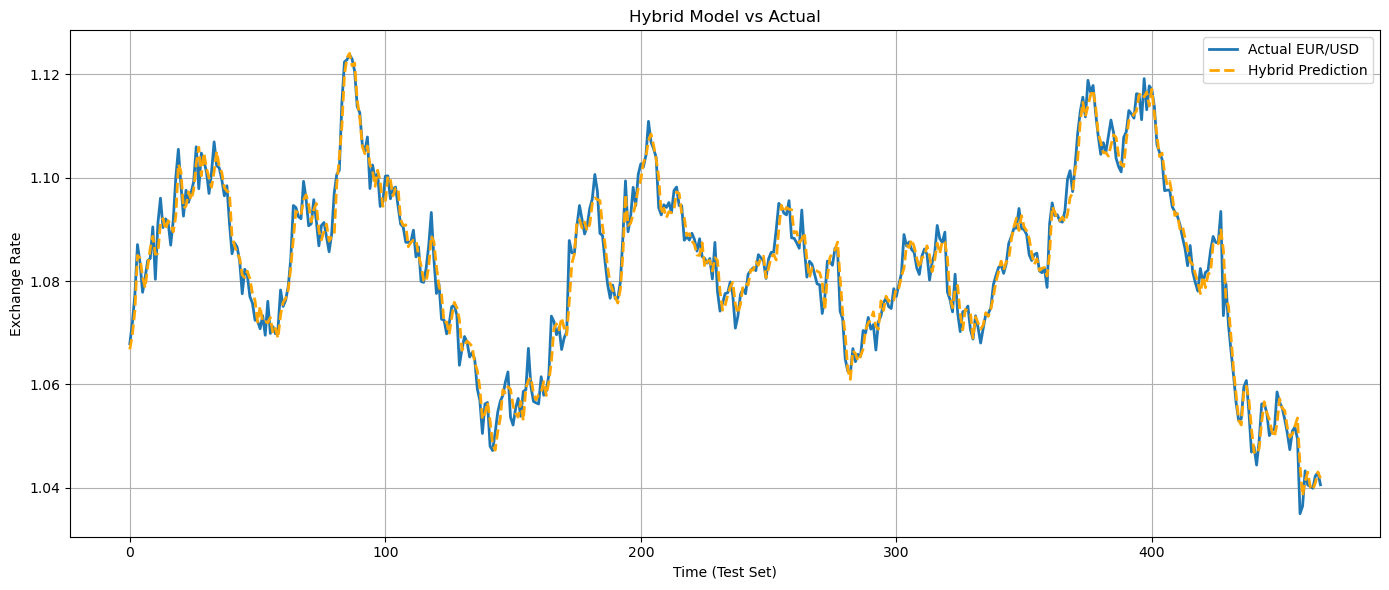

In [22]:
# Plotting the predictions of the final hybrid model vs the actual values
plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual EUR/USD', linewidth=2)
plt.plot(y_final, label='Hybrid Prediction', linestyle='--', linewidth=2, color='orange')
plt.title('Hybrid Model vs Actual')
plt.xlabel('Time (Test Set)')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

While the overall plot may suggest an almost perfect fit, a closer inspection reveals notable differences. The zoomed-in segments below highlight where the hybrid model performs well — and where it may struggle to capture short-term volatility.

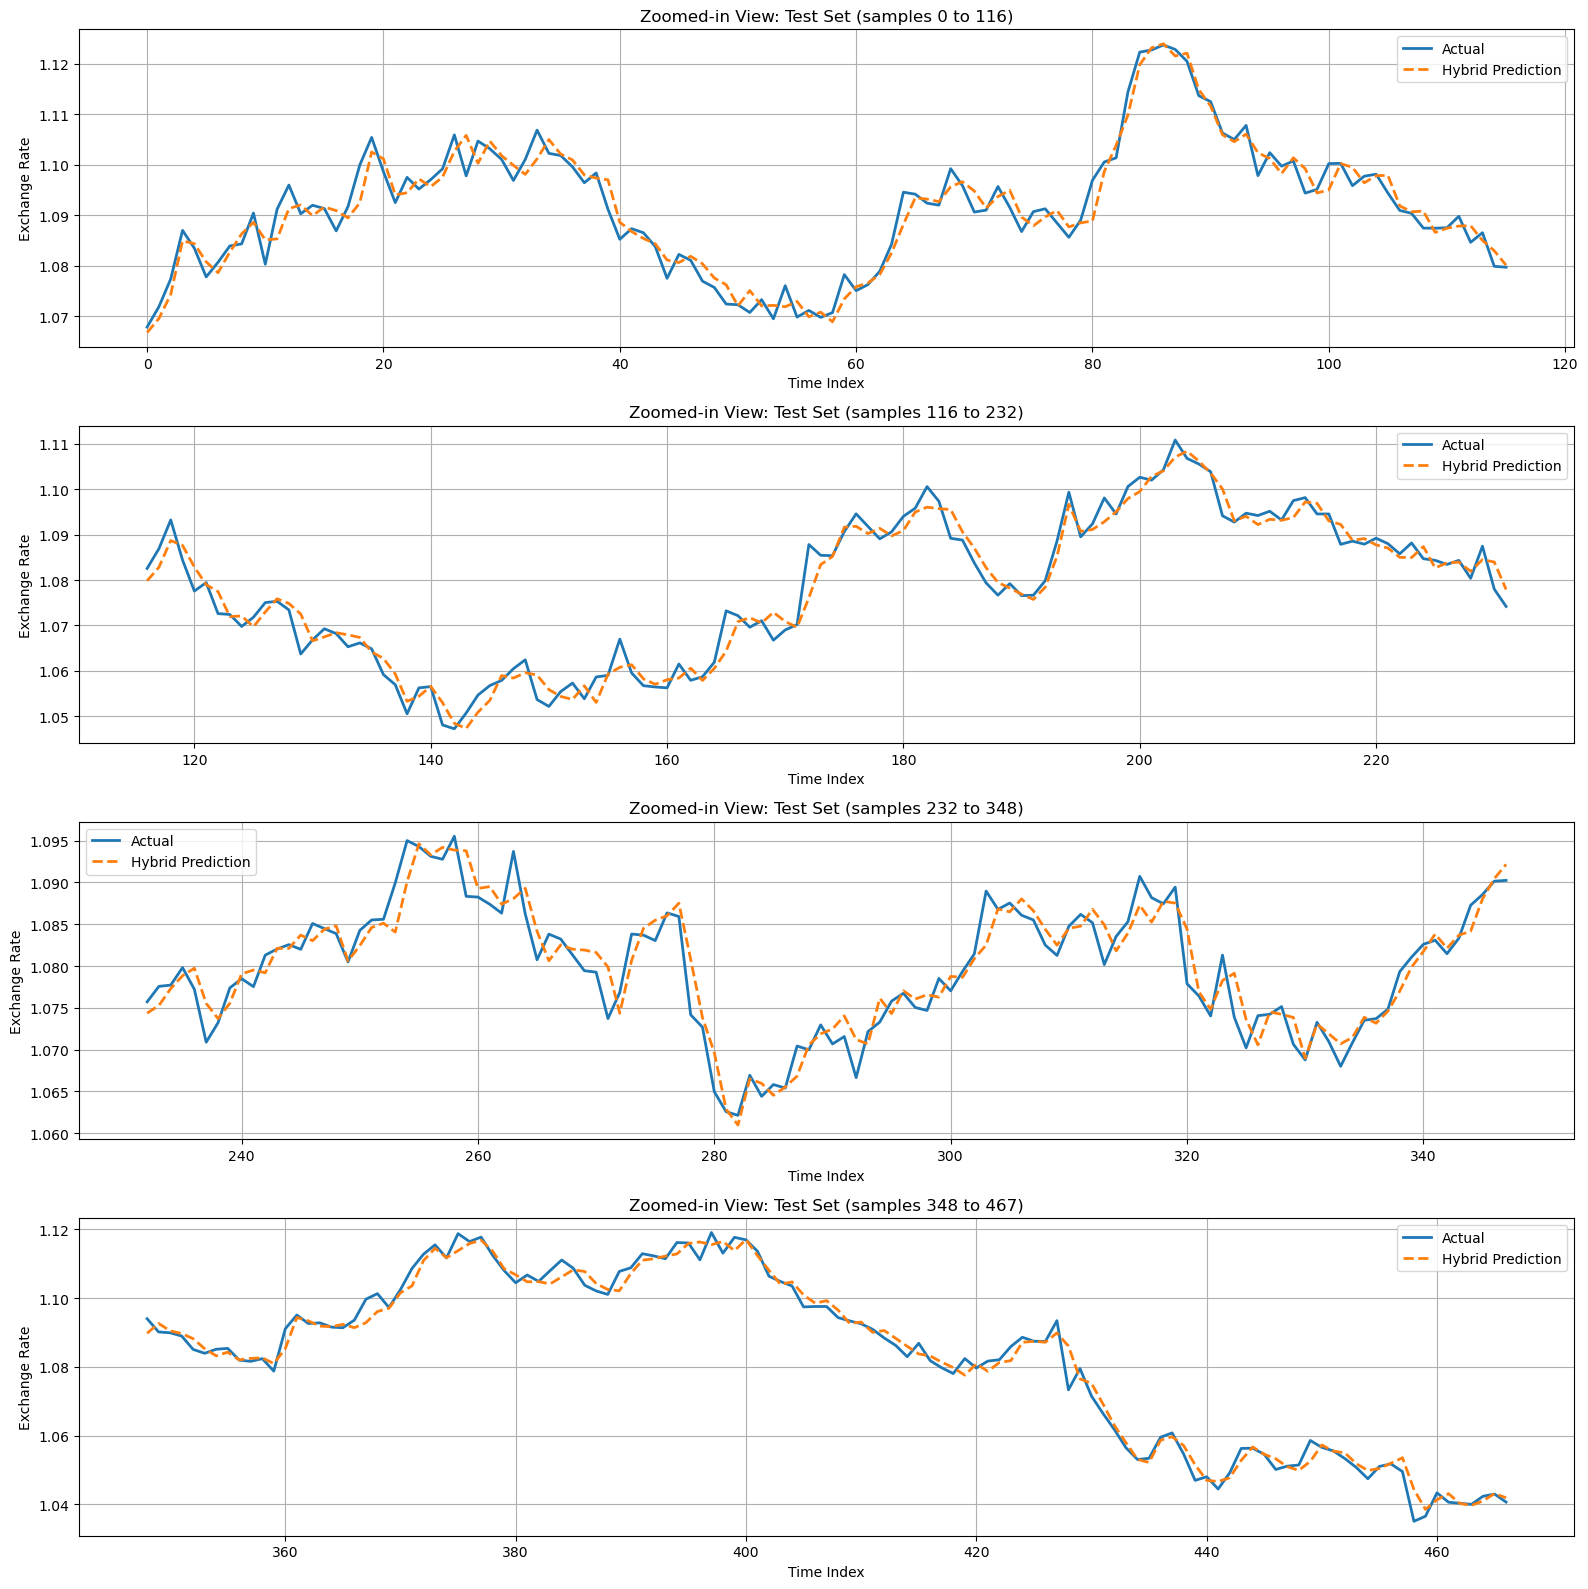

In [25]:
from hybrid_forecast_utils import plot_zoomed_predictions

# Call the function with your prediction results
plot_zoomed_predictions(y_true, y_final, n_subplots=4)

### Hybrid model performance on the test set

In [26]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae_final = mean_absolute_error(y_true, y_final)
mape_final = mean_absolute_percentage_error(y_true, y_final)
hybrid_acc = daily_directional_accuracy(y_true, y_final)
print("Final Hybrid Model Performance:")
print(f"Hybrid Model MAE: {mae_final:.6f}")
print(f"Hybrid Model MAPE: {mape_final * 100:.2f}%")
print(f"Hybrid Model Daily Directional Accuracy: {hybrid_acc:.2f}%")

Final Hybrid Model Performance:
Hybrid Model MAE: 0.002149
Hybrid Model MAPE: 0.20%
Hybrid Model Daily Directional Accuracy: 65.24%


At first glance, the Mean Absolute Error (MAE) of 0.002149 may seem impressive. However, it's important to interpret this figure relative to the actual scale of the EUR/USD exchange rate, which in the test period ranged from 1.0350 to 1.1238 — a variation of less than 9 cents across this specific time period.

An average error of 0.0021 means the model was, on average, off by about 0.20% of the true value, depending on where the rate was at each time step. This aligns well with the reported MAPE of 0.20%, a more informative metric when working with financial time series like FX rates. In this context, such a low MAPE indicates high numerical precision, especially for a univariate model.

However, Directional Accuracy (DA) — the percentage of times the model correctly predicted the direction of change — was 65.24%. While this is statistically better than random guessing (50%), it leaves room for improvement, especially in trading or hedging applications where getting the direction right is often more important than the magnitude of error.

In summary:

The MAE is small in absolute terms, but must be interpreted in the narrow context of the EUR/USD rate range.

The MAPE confirms the model’s ability to closely track actual values, proportionally.

The 65% Directional Accuracy, while decent, reminds us that predicting short-term direction in FX remains a highly challenging task, particularly with univariate inputs.

## Error Analysis

To ensure the validity and reliability of the hybrid model's predictions, we conducted a residual analysis.

In [27]:
residuals_hybrid = y_true - y_final

### Residual vs. Prediction Plot   
The residuals appear randomly scattered around zero with no clear trend or funnel shape, indicating that the model does not exhibit strong bias across prediction levels. This suggests the errors are evenly distributed, and the model maintains consistent performance regardless of the predicted EUR/USD value.

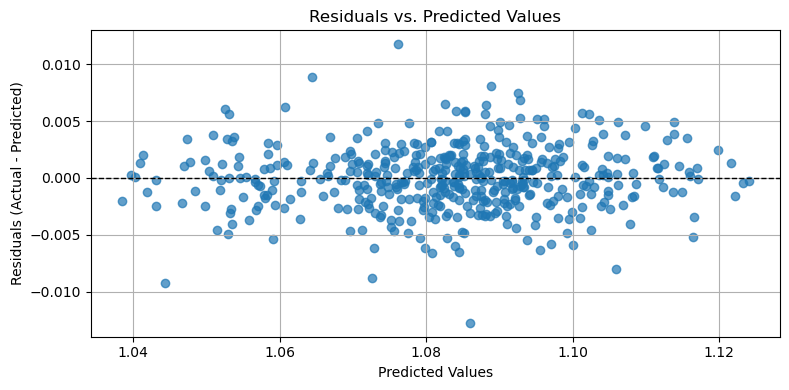

In [28]:
# Create residuals vs. predicted plot
plt.figure(figsize=(8, 4))
plt.scatter(y_final, residuals_hybrid, alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show();

### Residuals Over Time
This plot helps identify temporal patterns or structural shifts in model error.
The residuals appear randomly distributed around zero across the test period, with no visible drift, autocorrelation, or clustering.
This suggests that the model maintains temporal stability, and the forecasting errors do not increase or deteriorate over time.

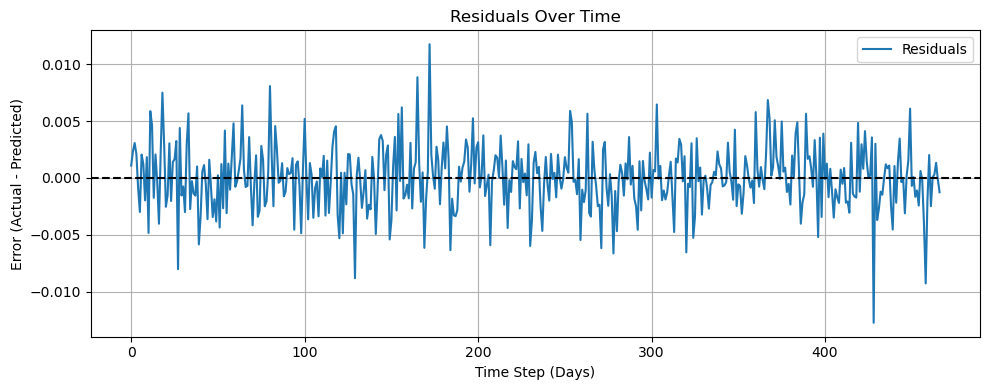

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(residuals_hybrid, label='Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Time Step (Days)')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show();

### Autocorrelation Diagnostic (Ljung–Box Test)
No statistical evidence of autocorrelation was found in the residuals, indicating the model has effectively captured the temporal structure of the series — a strong sign of model adequacy.

In [30]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_result = acorr_ljungbox(residuals_hybrid, lags=[5, 10, 20], return_df=True)
print(f"Ljung-Box p-value (lag 5): {lb_result['lb_pvalue'].iloc[0]:.4f}")
print(f"Ljung-Box p-value (lag 10): {lb_result['lb_pvalue'].iloc[1]:.4f}")
print(f"Ljung-Box p-value (lag 20): {lb_result['lb_pvalue'].iloc[2]:.4f}")

Ljung-Box p-value (lag 5): 0.3408
Ljung-Box p-value (lag 10): 0.4489
Ljung-Box p-value (lag 20): 0.2159


 ### Residual Distribution and Normality   
The histogram and KDE plot show the residuals are approximately symmetric, centered around zero, and bell-shaped — closely resembling a Gaussian distribution.
This is a desirable property in regression problems, supporting model stability, reliability, and valid statistical inference.

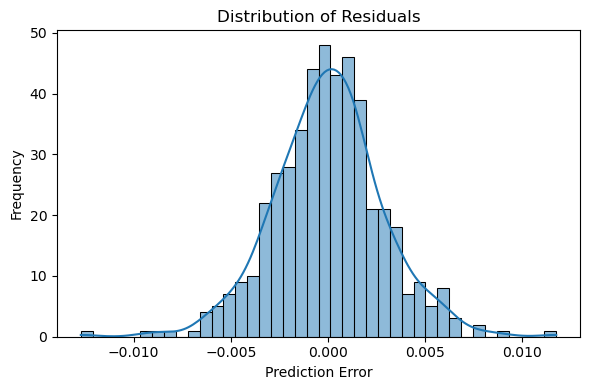

In [31]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.histplot(residuals_hybrid, bins=40, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show();

### Q-Q plot
The Q-Q plot shows that the residuals from the hybrid model are approximately normally distributed, with minor deviations in the tails. This confirms that the assumption of approximate normality holds, which supports the model's reliability and the validity of residual-based evaluation metrics.

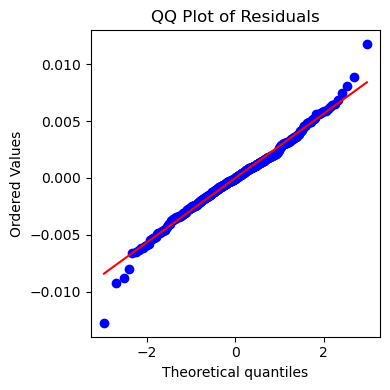

In [32]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
stats.probplot(residuals_hybrid, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.tight_layout()
plt.show();

## Rolling Window Evaluation

While the previous section focused on building and tuning a hybrid model using a static train/test split, real-world financial markets are dynamic and often exhibit structural changes over time.

To evaluate how well the model generalizes across different market regimes, we adopt a **rolling window backtesting framework**. This approach simulates a more realistic forecasting scenario by:

- **Training on a historical window** (e.g., 8 years)
- **Testing on the immediate next year**
- **Sliding the window forward one year at a time**

This methodology allows us to assess:
- The model’s **temporal stability and robustness**
- Performance consistency across **various economic periods** (e.g., post-crisis, pandemic, monetary tightening)
- Exposure to **concept drift**, where the relationship between past and future values may change

By observing error metrics and directional accuracy across multiple windows, we gain deeper insight into whether our hybrid model is **truly generalizable** — or overly reliant on specific patterns seen in the original training set.

In [ ]:
from hybrid_forecast_utils import hybrid_model_predict, rolling_window_backtest

results = rolling_window_backtest(
    series=series,
    index=eurusd_df.index,
    start_year=2007,
    end_year=2025,
    train_years=8,
    window_size=30,
    horizon=1
)
results

,Train Period,Test Period,Train Size,Test Size,MAE,MAPE,DA
0,2007–2014,2015,2058,261,0.002553,0.230105,79.230769
1,2008–2015,2016,2058,261,0.001940,0.175069,73.461538
2,2009–2016,2017,2057,260,0.001700,0.150869,76.447876
3,2010–2017,2018,2056,261,0.001830,0.155340,78.461538
4,2011–2018,2019,2056,261,0.001527,0.136423,73.076923
5,2012–2019,2020,2057,262,0.001809,0.158461,77.777778
6,2013–2020,2021,2058,261,0.001669,0.141032,71.538462
7,2014–2021,2022,2058,260,0.001992,0.189669,78.764479
8,2015–2022,2023,2057,260,0.001898,0.175462,76.833977
9,2016–2023,2024,2056,262,0.001504,0.139093,74.712644


In [ ]:
print(f"Average Rolling MAE: {results['MAE'].mean():.6f}")
print(f"Average Rolling MAPE: {results['MAPE'].mean():.2f}")
print(f"Average Rolling Daily Directional Accuracy: {results['DA'].mean():.2f}")

Average Rolling MAE: 0.001842
Average Rolling MAPE: 0.17
Average Rolling Daily Directional Accuracy: 76.03


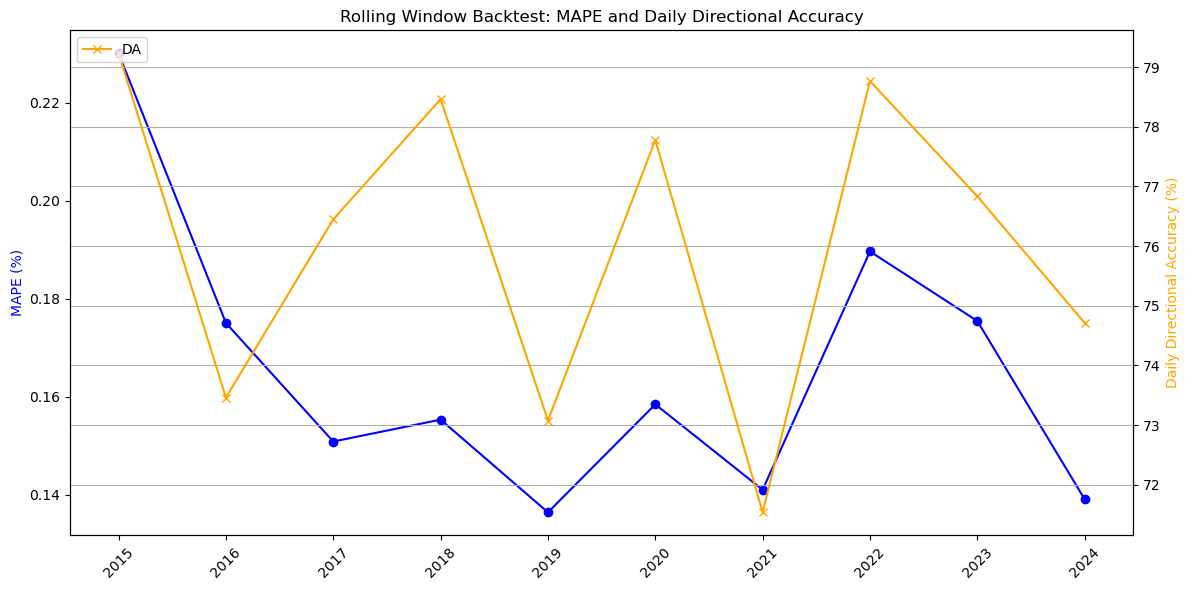

In [ ]:
# Plot MAPE on primary y-axis, DA on secondary y-axis
plt.figure(figsize=(12, 6))
plt.plot(results['Test Period'], results['MAPE'], marker='o', label='MAPE', color='blue')
plt.ylabel('MAPE (%)', color='blue')
plt.xticks(rotation=45)
plt.twinx()
plt.plot(results['Test Period'], results['DA'], marker='x', label='DA', color='orange')
plt.ylabel('Daily Directional Accuracy (%)', color='orange')
plt.title('Rolling Window Backtest: MAPE and Daily Directional Accuracy')
plt.grid()
plt.legend(loc='upper left')
plt.tight_layout()
plt.show();


## Closing Comment

This hybrid modeling experiment—combining a stacked LSTM-GRU neural network with an XGBoost regressor on residuals—demonstrated strong predictive power on historical data up to 2024.
On the test set, the model achieved:

- MAE: 0.002149

- MAPE: 0.20%

- Directional Accuracy: 65.24%

The model’s generalization capability was further validated through rolling window evaluation, yielding:

- Average Rolling MAE:  0.001842

- Average Rolling MAPE: 0.17%

- Average Rolling Daily Directional Accuracy: 76.03%

Despite training on a larger dataset (2007–2024), the hybrid model performed slightly worse on the full test set compared to the rolling windows evaluation. This may seem counterintuitive, but it highlights a key aspect of temporal modeling:

The full test set covers a broader time span (467 days), likely encompassing more varied market conditions—including volatility spikes or structural changes that the model wasn't optimally tuned to handle in aggregate.

In contrast, each rolling window test spans just one year (~252 days). This tighter temporal focus means each fold is trained and tested on more locally consistent patterns, potentially improving short-term predictive accuracy.

Also, data recency plays a role. Rolling windows continuously re-train with newer data, while the full set includes older patterns that may no longer be relevant—diluting model adaptability.

This reinforces that more data isn't always better—especially in financial time series where patterns evolve and structural breaks occur. Regular re-training and dynamic windowing remain essential tools for robust forecasting.


<u>Finaly we need to emphasize that while these results are more than promising—especially for a univariate baseline—several important caveats must be acknowledged</u>:  

**Univariate models trained solely on historical values can fail to generalize under shifting market conditions**.   
**Exchange rate dynamics are influenced by macroeconomic policy shifts, central bank actions, diplomatic incidents, geopolitical shocks, and sentiment-driven volatility—none of which a univariate model can capture(*except perhaps indirectly through lagged price reactions*)**

This underscores the importance of:  
- Continuous validation and performance monitoring
- Multivariate modeling with external variables  
- Adaptive systems that can retrain as market conditions evolve  
- Robust hybrid ensembles incorporating multiple model classes and timeframes

In conclusion, while this model offers a solid baseline, it may still underperform in the face of real-world complexity—**reminding us that forecasting is not just about fitting the past**.